# Convolutional Autoencoder for Image Denoising Demo

In this notebook, we will attempt to denoise MNIST images using a simple convolutional autoencoder. MNIST images consist of handwritten digits, while the dataset consists of clean images, we will articially add some noise to the image and train the autoencoder using these noisy images. 

For our example we will run it just for 5 epochs but for real world examples we'll need a lot more epochs. For demonstration, 5 is fine.

To run this notebook, I am using the following package versions:

* Tensorflow: 2.8.0

* Tensorflow datasets: 4.6.0

There might be minor variations in the code for different versions of these packages.

This implementation assumes some knowledge of building models with Tensorflow

## Import necessary packages

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

## Prepare the dataset

Autoencoders are self-supervised algorithms, which means there won't be a separate set of labels. We will be assigining the training images as the target labels.

As a part of data preparation, we will normalize the image by dividing it by 255 and add a random noise to the image. Normalizing images in general may improve the contrast and the smaller values speed up the training process.

The factor I've used is 0.5 but feel free to play around with that

In [2]:
def map_image_with_noise(image, og_label):
    '''Normalize inputs and add noise
       Parameters
       image: Grayscale input image
       og_label: Original assigned label, not used in modeling
       Outputs
       image_noisy: Normalised image with added noise
       image_target: Original normalised image without noise to be used as model target
    '''
    image = tf.cast(image, dtype=tf.float32)  #Grayscale float32 image
    image_target = image / 255.0 #Noramlize 
    noise_factor = 0.5
    # Prepare the input data by adding a random noise
    factor = noise_factor * tf.random.normal(shape=image_target.shape)
    image_noisy = image_target + factor
    image_noisy = tf.clip_by_value(image_noisy, 0.0, 1.0) ## In case the pixel values go out of range post adding noise
    return image_noisy, image_target

## Build the model

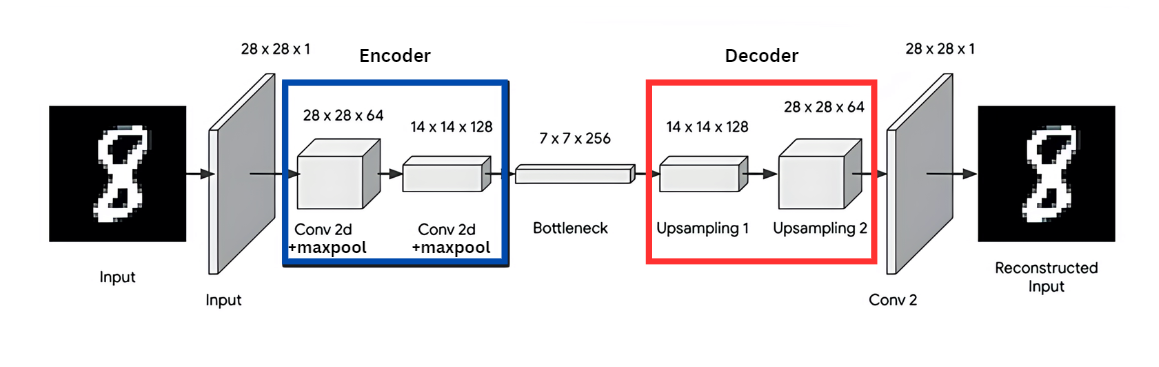

We'll be using 2 rounds of convolution (and we'll add a maxpooling layer after every convolution since I am setting the padding as same. We could have skipped the pooling and adjusted the padding and stride in the convolution layer but lets stick to the standard practise which is usually conv2d with padding as same followed by maxpooling to reduce dimensions.

### Defining the encoder 

We will keep this straigtforward - one layer of convolution 2D followed by maxpooling, a second layer of convolution 2D followed by another maxpool. 

In [3]:
def encoder(inputs):
    '''Defining the encoder with two Conv2D and max pooling layers. Encoder output is the output of the second maxpool
       Parameters
       inputs: input images, noisy images here
       Output:
       max_pool_2: output of the second maxpool layer i.e., encoder output
    '''
    conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)
    conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)
    return max_pool_2

### Defining the bottleneck

Check out the bottleneck in the diagram below, that's the region we'll define now. This is be the most compressed form of the inputs. Add a layer with one conv2D and we are done. We also want to create the option to visualise the encoder output so we create. The additional conv2D is just to make the bottleneck layer visually interpretable. One 3x3 filter with sigmoid activation is used just for visualization.

In [4]:
def bottleneck_layer(inputs):
    '''Defining the bottleneck
       Parameters
       inputs: Encoder output is the input here
       Outputs
       bottleneck: output of the bottleneck layer for use in the decoder
       encoder_visiualization: The latent space with some manipulations to make it visually interpretable
    '''
    bottleneck = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(bottleneck)
    return bottleneck, encoder_visualization

### Defining the decoder 

Since we have 2 rounds of downsampling with the convolution and max pooling, we perform two rounds of upsampling here using Conv2D. I'm using Upsampling2D in this example which uses interpolative resizing in the tensorflow version. You could try using Conv2DTranspose as well for this.

In [5]:
def decoder(inputs):
    '''Defining the decoder path to upsample to the original image size
       Parameters
       inputs: Bottleneck output, not the one with the additional conv2d and sigmoid activation
       Output
       conv_3: Output of 2 rounds of upsampling followed by a single 3x3 filter and sigmoid to turn it back into an image
    '''
    conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)

    conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_sample_1)
    up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)

    conv_3 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(up_sample_2)

    return conv_3

### Putting it all together to build the autoencoder

In [6]:
def convolutional_auto_encoder():
    '''Put the model together
       Output
       model: The entire autoencoder model
       encoder_model: Just the encoder'''
    #Define the inputs
    inputs = tf.keras.layers.Input(shape=(28, 28, 1,))
    #Get the encoder output
    encoder_output = encoder(inputs)
    #Store the outputs of the bottleneck layer for visualisation and analysis
    bottleneck_output, encoder_visualization = bottleneck_layer(encoder_output)
    #Get the decoder output
    decoder_output = decoder(bottleneck_output)
    #Put it together and get your model
    model = tf.keras.Model(inputs =inputs, outputs=decoder_output)
    encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
    return model, encoder_model
     

In [7]:
# Lets call the model now
convolutional_model, convolutional_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()
     

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         295168

### Prepare for training

All our functions are ready. Now lets define the batch size, prepare the noisy training images and test dataset

In [8]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image_with_noise) ## Add noise to the training images
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_dataset = tfds.load('mnist', as_supervised=True, split="test")
val_dataset = val_dataset.map(map_image_with_noise) ## Add noise to the validation dataset
val_dataset = val_dataset.batch(BATCH_SIZE).repeat()

In [9]:
train_steps = 60000 // BATCH_SIZE
valid_steps = 60000 // BATCH_SIZE

convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
conv_model_history = convolutional_model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=val_dataset, validation_steps=valid_steps, epochs=5)
     

Epoch 1/5
468/468 [==============================] - 193s 411ms/step - loss: 0.1355 - val_loss: 0.1045
Epoch 2/5
468/468 [==============================] - 189s 404ms/step - loss: 0.1007 - val_loss: 0.0975
Epoch 3/5
468/468 [==============================] - 187s 400ms/step - loss: 0.0975 - val_loss: 0.0958
Epoch 4/5
468/468 [==============================] - 203s 435ms/step - loss: 0.0958 - val_loss: 0.0940
Epoch 5/5
468/468 [==============================] - 197s 421ms/step - loss: 0.0945 - val_loss: 0.0933


### Display results

Now lets put together a few plots and modify the images for the visualization 

In [10]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, noisy_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    noisy_image = np.reshape(noisy_image, shape)
    plt.imshow(noisy_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Display the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,))
     

Now lets have a look the model inputs and outputs

In [11]:
# Lets try things out with one batch of the dataset
test_dataset = test_dataset.take(1)
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick any 10 images
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Test things out with these 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

# get the encoder
encoded = convolutional_encoder_model.predict(conv_output_samples)

# get the predictions
predicted = convolutional_model.predict(conv_output_samples)

# And display the results
display_results(conv_output_samples, encoded, predicted, enc_shape=(7,7))

NameError: name 'test_dataset' is not defined